# Transformer For Variable Length Sequences


In [1]:
# !conda install -c conda-forge pyspark
# !pip show pyspark
# !java -version

In [2]:
import os
import sys
import datetime
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from pyspark.sql import  SparkSession, Row, functions as F
from pyspark.sql.types import ArrayType, StringType, IntegerType, BooleanType

import torch
from torch.nn.utils.rnn import pad_sequence

import utils
from ts2vec import datautils

In [3]:
DATA_PATH = './data'
TB_DATASET = 'UserBehaviorSample.csv'

## 1. 集成到 `utils.py`

为了方便复用，将上一节的时间序列 Transformer 模型写成一个类 `TSTransformer`，集成到 `utils.py` 中。

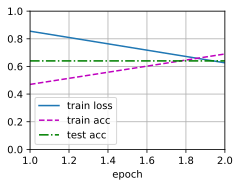

In [4]:
# 分割训练集和验证集
X_train, y_train, X_test, y_test = datautils.load_UCR('ECG200')
X_shape = X_train.shape[2]

# X_train = [torch.tensor(seq, dtype=torch.float32) for seq in X_train]
# X_test = [torch.tensor(seq, dtype=torch.float32) for seq in y_train]
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

tst = utils.TSTransformer(input_dim=X_shape,
                          model_dim=8,
                          nhead=4,
                          num_layers=2,
                          hidden_dim=32,
                          num_classes=2,
                          num_epochs=2,
                          batch_size=25)
predict, metrics = tst(X_train, y_train, X_test, y_test)

In [5]:
print(f'Top 5 predict labels: {predict[:5]}')

for k, v in metrics.items():
    print(f'{k}: {v:.4f}')

Top 5 predict labels: [1, 1, 1, 1, 1]
train_loss: 0.6261
train_acc: 0.6900
test_acc: 0.6400


## 2. 不定长序列

上一节，我们生成了定长序列的嵌入表示，本节我们来尝试不定长序列。

淘宝用户行为数据集是一个不定长的行为序列数据集，链接：[TianChi](https://tianchi.aliyun.com/dataset/649) | [Kaggle](https://www.kaggle.com/datasets/marwa80/userbehavior)

从上述链接，将数据文件 `UserBehavior.csv` 下载到 `data` 文件夹中。由于数据文件极大，本文只取前 10000 条数据，用于演示。

各字段含义如下：

|Field|Explanation|
| -- | -- |
|User ID|An integer, the serialized ID that represents a user|
|Item ID|An integer, the serialized ID that represents an item|
|Category ID|An integer, the serialized ID that represents the category which the corresponding item belongs to|
|Behavior type|A string, enum-type from ('pv', 'buy', 'cart', 'fav')|
|Timestamp|An integer, the timestamp of the behavior|

### 2.1 导入数据

In [6]:
# 导入数据
csv_path = utils.gen_abspath(DATA_PATH, TB_DATASET)
df = utils.read_csv(csv_path, header=None)
df.columns = ['User ID', 'Item ID', 'Category ID', 'Behavior type', 'Timestamp']

# df

### 2.2 数据预处理

- 对文本字段进行编码
- 将时间戳转换成时间

In [7]:
# 将 Behavior type 编码成数字
behavior_type = df['Behavior type']
cv = utils.Convert(behavior_type)
df['Behavior type'] = df['Behavior type'].apply(cv.encoder)

# 将时间戳转换成日期
df['Time'] = df['Timestamp'].apply(datetime.datetime.fromtimestamp)

df

,User ID,Item ID,Category ID,Behavior type,Timestamp,Time
0,1,2268318,2520377,0,1511544070,2017-11-25 01:21:10
1,1,2333346,2520771,0,1511561733,2017-11-25 06:15:33
2,1,2576651,149192,0,1511572885,2017-11-25 09:21:25
3,1,3830808,4181361,0,1511593493,2017-11-25 15:04:53
4,1,4365585,2520377,0,1511596146,2017-11-25 15:49:06
...,...,...,...,...,...,...
999996,128600,4935668,2640118,1,1511826588,2017-11-28 07:49:48
999997,128600,3175221,2640118,1,1511826676,2017-11-28 07:51:16
999998,128600,3840425,2640118,0,1511826695,2017-11-28 07:51:35
999999,128600,2495970,2640118,1,1511826739,2017-11-28 07:52:19


### 2.3 生成行为序列

对数据进行 reshape 操作，将数据做成 `(样本量, 步长, 特征数)` 的形状。

> 在本地运行 Spark 可能需要一些配置：
> - `spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")` enables the use of Apache Arrow for data exchange between PySpark (Python) and JVM (Java Virtual Machine) in Spark.

In [8]:
python_path = sys.executable

os.environ['PYSPARK_PYTHON'] = python_path
os.environ['PYSPARK_DRIVER_PYTHON'] = python_path

# 创建 SparkSession
spark = SparkSession.builder \
    .appName("App") \
    .config("spark.pyspark.python", python_path) \
    .config("spark.pyspark.driver.python", python_path) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", 2) \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# 将 Pandas DataFrame 加载到 Spark
spark_df = spark.createDataFrame(df)
spark_df.show(5, truncate=False)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/13 03:42:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/changluo/miniforge3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


+-------+-------+-----------+-------------+----------+-------------------+
|User ID|Item ID|Category ID|Behavior type|Timestamp |Time               |
+-------+-------+-----------+-------------+----------+-------------------+
|1      |2268318|2520377    |0            |1511544070|2017-11-25 01:21:10|
|1      |2333346|2520771    |0            |1511561733|2017-11-25 06:15:33|
|1      |2576651|149192     |0            |1511572885|2017-11-25 09:21:25|
|1      |3830808|4181361    |0            |1511593493|2017-11-25 15:04:53|
|1      |4365585|2520377    |0            |1511596146|2017-11-25 15:49:06|
+-------+-------+-----------+-------------+----------+-------------------+
only showing top 5 rows



In [9]:
is_buy = cv.encoder('buy')

# 对特征做预聚合 Item ID, Category ID, Behavior type, Timestamp
# 染红按 User ID 分组，对 item_rec 去重，并用 `;` 拼接
items_df = spark_df.withColumn('features', F.concat_ws('_', F.col('Item ID'), F.col('Category ID'), F.col('Behavior type'), F.col('Timestamp'))) \
    .withColumn('item_rec', F.concat_ws(',', F.col('Timestamp'), F.col('features'))) \
    .groupBy('User ID').agg(
        F.concat_ws(';', F.collect_set('item_rec')).alias('item_list'),
        F.max(F.when(F.col("Behavior type") == is_buy, 1).otherwise(0)).alias("is_buy"))

items_df.show(5)

+-------+--------------------+------+
|User ID|           item_list|is_buy|
+-------+--------------------+------+
|   1119|1511549010,247759...|     1|
|   1212|1511740193,268563...|     1|
|   1241|1511843821,134999...|     1|
|  10078|1512195921,148092...|     1|
|  10146|1511661483,464810...|     1|
+-------+--------------------+------+
only showing top 5 rows



In [10]:
def sorted_items(items: str,
                 main_delimiter: str = ';',
                 minor_delimiter: str = ','):
    """按时间顺序对用户行为排序"""
    if len(items) == 0:
        return []

    item_list = []
    for kv in items.split(main_delimiter):
        kv_list = kv.split(minor_delimiter)
        if len(kv_list) == 2:
            item_list.append(kv_list)

    sorted_list = sorted(item_list, key=lambda e: e[0])
    sorted_items = [e[1] for e in sorted_list]
    return [[key for key, _ in itertools.groupby(sorted_items)]]

sorted_items('2015-03-15,0;2015-05-27,3;2015-03-16,0;2014-03-16,1')

[['1', '0', '3']]

In [11]:
# 将函数注册为 Spark UDF，返回值类型为 String
sort_udf = F.udf(sorted_items, ArrayType(ArrayType(StringType())))

# 在 DataFrame 上应用此函数
sorted_items_df = items_df.withColumn('item_list', sort_udf(F.col('item_list'))) \
    .withColumn('item_list', F.col('item_list').getItem(0)) \
    .withColumnRenamed('item_list', 'sequence') \
    .withColumnRenamed('User ID', 'uid')

# sorted_items_df.show(1, truncate=False)

In [18]:
# 把数据从 Spark 拉下来存成字典，key 是 uid，value 是特征/标签
feat_dict = {row.uid: [list(map(int, e.split('_'))) for e in row.sequence] for row in sorted_items_df.collect()}
label_dict = {row.uid: row.is_buy for row in sorted_items_df.collect()}

# 将特征和标签转为 DataFrame
df_feat = pd.DataFrame({
    'uid': feat_dict.keys(),
    'features': feat_dict.values()})
df_label = pd.DataFrame({
    'uid': label_dict.keys(),
    'label': label_dict.values()})
df_join = pd.merge(df_feat, df_label, on='uid', how='inner')

# 保存中间表
csv_path = utils.gen_abspath(DATA_PATH, 'df_join.csv')
df_join.to_csv(csv_path, index=False)

df_join

,uid,features,label
0,1119,"[[3186572, 1817004, 0, 1511539933], [5132990, ...",1
1,1212,"[[2689262, 846990, 3, 1511581905], [4248207, 1...",1
2,1241,"[[1034291, 1609467, 0, 1511582777], [4849005, ...",1
3,10078,"[[2418601, 4145813, 0, 1511697971], [697590, 7...",1
4,10146,"[[1549960, 3177764, 0, 1511620754], [1690150, ...",1
...,...,...,...
9734,1017719,"[[3127570, 979761, 0, 1511570528], [4250048, 4...",1
9735,1017730,"[[4130399, 4708348, 0, 1511609398], [2276333, ...",1
9736,1017850,"[[2116684, 3459562, 0, 1511583980], [1370809, ...",1
9737,1017904,"[[4320853, 84264, 0, 1511569491], [4073444, 15...",1


In [12]:
# 样本和标签
# 目前特征的第四维是时间戳，需要将它改造成该用户当前时间戳与上一个时间戳的差
X, y = [], []
for _, row in df_join.iterrows():
    feats, new_feats = row['features'][::-1], []
    for i, feat in enumerate(feats):
        if i < len(feats) - 1:
            feat[3] = feat[3] - feats[i+1][3]
        else:
            feat[3] = 0
        new_feats.append(feat)
    X.append(new_feats[::-1])
    y.append(row['label'])

# X, y

In [13]:
seq_len_list = [len(e) for e in X]

print(f'用户数：{len(X)}')
print(f'最长行为序列：{max(seq_len_list)}')
print(f'最短行为序列：{min(seq_len_list)}')

用户数：9739
最长行为序列：781
最短行为序列：2


In [14]:
# 只考虑至多最近 N 个行为
N = 300
assert N <= max(seq_len_list)

trunc_X = [seq[-N:] for seq in X]
seq_len_list = [len(e) for e in trunc_X]
print(f'最长行为序列：{max(seq_len_list)}')

最长行为序列：300


In [15]:
def padding(X):
    sequences = pad_sequence([torch.tensor(seq) for seq in X], batch_first=True)
    lengths = torch.tensor([len(x) for x in X])
    key_padding_mask = torch.arange(sequences.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)

    return sequences, key_padding_mask

X_tensor, mask = padding(trunc_X)
y_tensor = torch.tensor(y, dtype=torch.long)

X_tensor.shape, y_tensor.shape, mask.shape

(torch.Size([9739, 300, 4]), torch.Size([9739]), torch.Size([9739, 300]))

In [16]:
# 将数据和标签拆分成训练集和测试集
X_train, X_test, y_train, y_test, X_mask, y_mask = train_test_split(X_tensor,
                                                                    y_tensor,
                                                                    mask,
                                                                    test_size=0.2,
                                                                    random_state=42)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_mask.shape: {X_mask.shape}')
print(f'y_mask.shape: {y_mask.shape}')

X_train.shape: torch.Size([7791, 300, 4])
X_test.shape: torch.Size([1948, 300, 4])
y_train.shape: torch.Size([7791])
y_test.shape: torch.Size([1948])
X_mask.shape: torch.Size([7791, 300])
y_mask.shape: torch.Size([1948, 300])


In [17]:
input_dim = X_train.shape[2]
tst = utils.TSTransformer(input_dim=input_dim,
                          model_dim=16,
                          nhead=4,
                          num_layers=4,
                          hidden_dim=32,
                          num_classes=2,
                          num_epochs=100,
                          batch_size=256,
                          is_fixed=False)
predict, metrics = tst(X_train, y_train, X_test, y_test, X_mask, y_mask)


KeyboardInterrupt



Error in callback <function flush_figures at 0x1306820e0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt

